Import all libraries and functions

In [23]:
from functions import *

## Sales Prediction

In [24]:
df_sales = pd.read_csv('../../data/cleaned/df_sales.csv',parse_dates=['purchase_timestamp'])
df_sales = df_sales.copy()

In [25]:
data_exploration(df_sales)

Number of rows: 109559
Number of columns: 19
Number of duplicates: 0

Numerical Columns: Index(['item_id', 'price', 'freight_value', 'zip_code_prefix', 'latitude',
       'longitude', 'hour', 'month'],
      dtype='object')

Categorical Columns: Index(['order_id', 'product_id', 'customer_id', 'city', 'state_code',
       'state_name', 'category', 'category_english', 'day_of_week', 'season'],
      dtype='object')


,Column,Data Type,Non-Null Count,Missing Values,Unique Values
0,order_id,object,109559,0,95906
1,item_id,int64,109559,0,21
2,product_id,object,109559,0,32118
3,price,float64,109559,0,5835
4,freight_value,float64,109559,0,6883
5,customer_id,object,109559,0,95906
6,purchase_timestamp,datetime64[ns],109559,0,95389
7,zip_code_prefix,int64,109559,0,14648
8,city,object,109559,0,3996
9,state_code,object,109559,0,26


#### Group sales per day

Take the date only from the purchase_timestamp

In [26]:
df_sales['purchase_date'] = pd.to_datetime(df_sales['purchase_timestamp'].dt.date)

In [27]:
df_sales.dtypes

order_id                      object
item_id                        int64
product_id                    object
price                        float64
freight_value                float64
customer_id                   object
purchase_timestamp    datetime64[ns]
zip_code_prefix                int64
city                          object
state_code                    object
latitude                     float64
longitude                    float64
state_name                    object
category                      object
category_english              object
day_of_week                   object
hour                           int64
month                          int64
season                        object
purchase_date         datetime64[ns]
dtype: object

In [28]:
sales_per_day = df_sales.groupby('purchase_date')['price'].sum().reset_index()

In [29]:
sales_per_day = sales_per_day.rename(columns={'purchase_date':'ds','price':'y'})

In [30]:
sales_per_day.dtypes

ds    datetime64[ns]
y            float64
dtype: object

Save sales_per_day into a csv file to be used in Streamlit app.

In [124]:
sales_samples = sales_per_day.rename(columns={'ds':'date','y':'sales'})
sales_samples.to_csv('../../data/cleaned/sales_samples.csv', index=False) 

### Machine Learning with Prophet

In [31]:
m = Prophet()
m.fit(sales_per_day)

12:09:33 - cmdstanpy - INFO - Chain [1] start processing
12:09:33 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
972,2019-08-25
973,2019-08-26
974,2019-08-27
975,2019-08-28
976,2019-08-29


The predict method will assign each row in future a predicted value which it names `yhat`.<br>

The `forecast` object here is a new dataframe that includes a column `yhat` with the forecast, as well as columns for components and uncertainty intervals.

In [33]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
972,2019-08-25,15529.775800,3811.740852,26970.769992
973,2019-08-26,22571.459656,11258.329935,33849.607629
974,2019-08-27,21984.524351,10452.067633,33980.578992
975,2019-08-28,21130.100091,10181.389278,33254.089124
976,2019-08-29,20290.145997,9016.258587,31473.829865


In [34]:
forecast.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-09-15,-1107.935930,-10845.331760,11089.878386,-1107.935930,-1107.935930,934.336009,934.336009,934.336009,934.336009,934.336009,934.336009,0.0,0.0,0.0,-173.599921
1,2016-10-03,-21.393211,-7261.553142,13337.075085,-21.393211,-21.393211,3145.789895,3145.789895,3145.789895,3145.789895,3145.789895,3145.789895,0.0,0.0,0.0,3124.396683
2,2016-10-04,38.970273,-8168.772880,12637.042876,38.970273,38.970273,2582.141181,2582.141181,2582.141181,2582.141181,2582.141181,2582.141181,0.0,0.0,0.0,2621.111454
3,2016-10-05,99.333757,-8559.613112,12088.518686,99.333757,99.333757,1751.003512,1751.003512,1751.003512,1751.003512,1751.003512,1751.003512,0.0,0.0,0.0,1850.337269
4,2016-10-06,159.697242,-9550.540787,12253.698698,159.697242,159.697242,934.336009,934.336009,934.336009,934.336009,934.336009,934.336009,0.0,0.0,0.0,1094.033251


In [35]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

c:\Users\Gebruiker\anaconda3\envs\env_project_final\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Gebruiker\anaconda3\envs\env_project_final\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


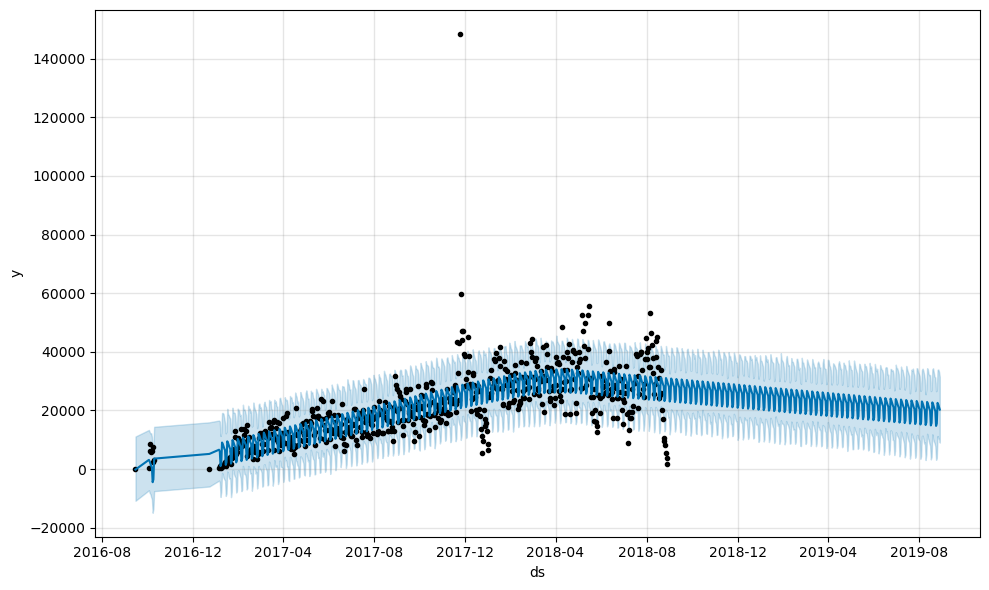

In [36]:
fig1 = m.plot(forecast)

c:\Users\Gebruiker\anaconda3\envs\env_project_final\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


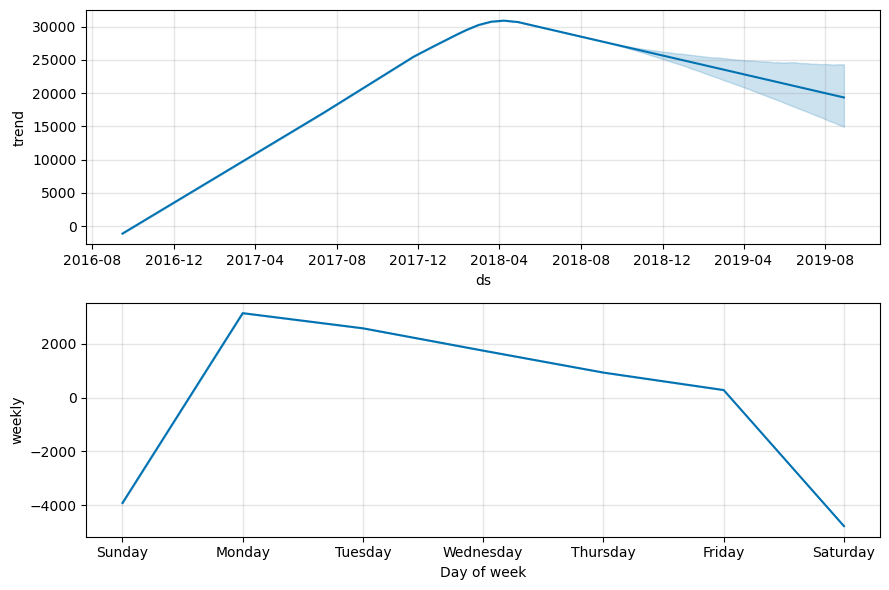

In [37]:
fig2 = m.plot_components(forecast)

Save the result in a new csv file

In [38]:
# List of important columns for visualization
important_columns = [
    'ds',              # Date
    'yhat',            # Forecast
    'yhat_lower',      # Lower bound of forecast
    'yhat_upper',      # Upper bound of forecast
    'trend',           # Trend component
    'weekly',          # Weekly seasonality
    'additive_terms'   # Sum of seasonal components
]


In [39]:
forecast_without_holidays = forecast[important_columns]

In [40]:
forecast_without_holidays.head()

,ds,yhat,yhat_lower,yhat_upper,trend,weekly,additive_terms
0,2016-09-15,-173.599921,-10845.331760,11089.878386,-1107.935930,934.336009,934.336009
1,2016-10-03,3124.396683,-7261.553142,13337.075085,-21.393211,3145.789895,3145.789895
2,2016-10-04,2621.111454,-8168.772880,12637.042876,38.970273,2582.141181,2582.141181
3,2016-10-05,1850.337269,-8559.613112,12088.518686,99.333757,1751.003512,1751.003512
4,2016-10-06,1094.033251,-9550.540787,12253.698698,159.697242,934.336009,934.336009


In [41]:
sales_forecast = forecast_without_holidays.rename(columns={
                'ds':'purchase_date',
                'yhat': 'total_sales_forecast',
                'yhat_lower':'total_sales_lower_bound',
                'yhat_upper':'total_sales_upper_bound',
                'trend': 'trend_component',
                'additive_terms': 'sum_seasonal_components'
                })

In [42]:
sales_forecast.head(3)

,purchase_date,total_sales_forecast,total_sales_lower_bound,total_sales_upper_bound,trend_component,weekly,sum_seasonal_components
0,2016-09-15,-173.599921,-10845.331760,11089.878386,-1107.935930,934.336009,934.336009
1,2016-10-03,3124.396683,-7261.553142,13337.075085,-21.393211,3145.789895,3145.789895
2,2016-10-04,2621.111454,-8168.772880,12637.042876,38.970273,2582.141181,2582.141181


In [43]:
sales_forecast.to_csv('../../data/cleaned/sales_forecast.csv', index=False)

Save the model as a pikle file

In [44]:
with open('../../src/prophet.pkl', 'wb') as file:
    pickle.dump(m, file)

#### Include Holiday

In [45]:
m = Prophet()

# Add Brazilian holidays
m.add_country_holidays(country_name='BR')

In [46]:
# Fit the model
m.fit(sales_per_day)

12:09:38 - cmdstanpy - INFO - Chain [1] start processing
12:09:38 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# Create future dataframe for predictions
future = m.make_future_dataframe(periods=365)

In [48]:
# Make predictions
forecast_with_holidays = m.predict(future)

In [49]:
forecast_with_holidays.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Confraternização Universal,Confraternização Universal_lower,Confraternização Universal_upper,Dia do Trabalhador,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-09-15,-868.109463,-10120.279406,10477.342861,-868.109463,-868.109463,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,950.452110,950.452110,950.452110,0.0,0.0,0.0,82.342647
1,2016-10-03,206.481612,-6941.196187,13941.901933,206.481612,206.481612,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3537.484619,3537.484619,3537.484619,0.0,0.0,0.0,3743.966231
2,2016-10-04,266.181117,-7088.396924,12873.513896,266.181117,266.181117,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2456.861430,2456.861430,2456.861430,0.0,0.0,0.0,2723.042546
3,2016-10-05,325.880621,-8356.063607,11342.906896,325.880621,325.880621,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1649.226442,1649.226442,1649.226442,0.0,0.0,0.0,1975.107063
4,2016-10-06,385.580125,-8659.607999,11492.822091,385.580125,385.580125,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,950.452110,950.452110,950.452110,0.0,0.0,0.0,1336.032235


In [50]:
forecast_with_holidays.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Confraternização Universal', 'Confraternização Universal_lower',
       'Confraternização Universal_upper', 'Dia do Trabalhador',
       'Dia do Trabalhador_lower', 'Dia do Trabalhador_upper', 'Finados',
       'Finados_lower', 'Finados_upper', 'Independência do Brasil',
       'Independência do Brasil_lower', 'Independência do Brasil_upper',
       'Natal', 'Natal_lower', 'Natal_upper', 'Nossa Senhora Aparecida',
       'Nossa Senhora Aparecida_lower', 'Nossa Senhora Aparecida_upper',
       'Proclamação da República', 'Proclamação da República_lower',
       'Proclamação da República_upper', 'Sexta-feira Santa',
       'Sexta-feira Santa_lower', 'Sexta-feira Santa_upper', 'Tiradentes',
       'Tiradentes_lower', 'Tiradentes_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'holidays',
       'holidays_lower', 'holidays_upper', 'weekly', 'weekly_lower',
       'weekly

In [51]:
# Get the list of holiday columns
holiday_columns = [col for col in forecast_with_holidays.columns if col not in ['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper']]

# Create a DataFrame with holiday effects
holiday_effects = forecast_with_holidays[['ds'] + holiday_columns]

# Print rows where any holiday has an effect
print(holiday_effects[holiday_effects.iloc[:, 1:].any(axis=1)].head(5))


            ds  Confraternização Universal  Confraternização Universal_lower  \
109 2017-04-14                         0.0                               0.0   
116 2017-04-21                         0.0                               0.0   
126 2017-05-01                         0.0                               0.0   
255 2017-09-07                         0.0                               0.0   
290 2017-10-12                         0.0                               0.0   

     Confraternização Universal_upper  Dia do Trabalhador  \
109                               0.0            0.000000   
116                               0.0            0.000000   
126                               0.0        -2395.963649   
255                               0.0            0.000000   
290                               0.0            0.000000   

     Dia do Trabalhador_lower  Dia do Trabalhador_upper  Finados  \
109                  0.000000                  0.000000      0.0   
116             

c:\Users\Gebruiker\anaconda3\envs\env_project_final\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Gebruiker\anaconda3\envs\env_project_final\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20060\1226179711.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


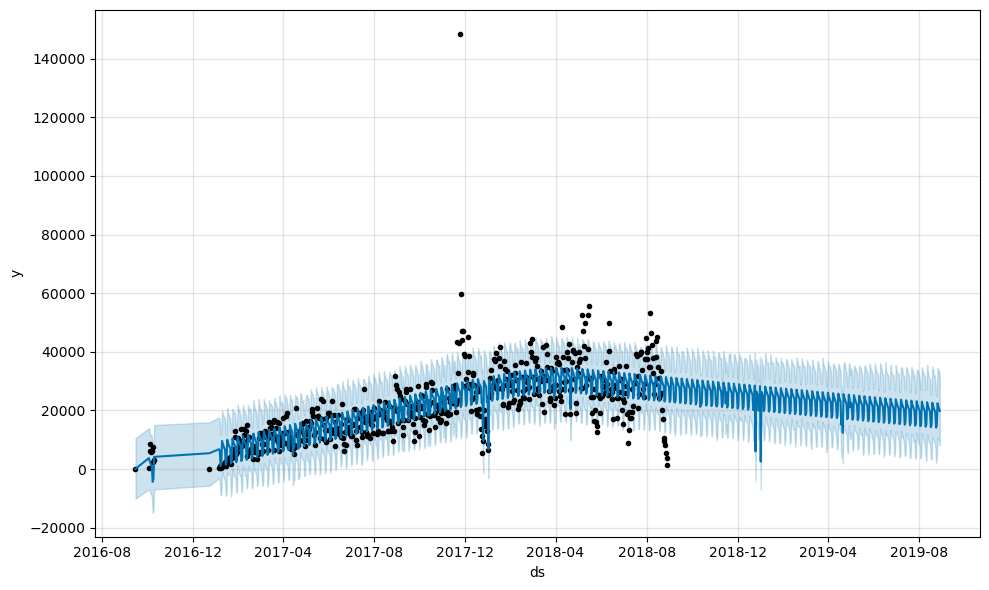

In [52]:
# Plot the forecast
fig = m.plot(forecast_with_holidays)
fig.show()


c:\Users\Gebruiker\anaconda3\envs\env_project_final\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20060\2890112259.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


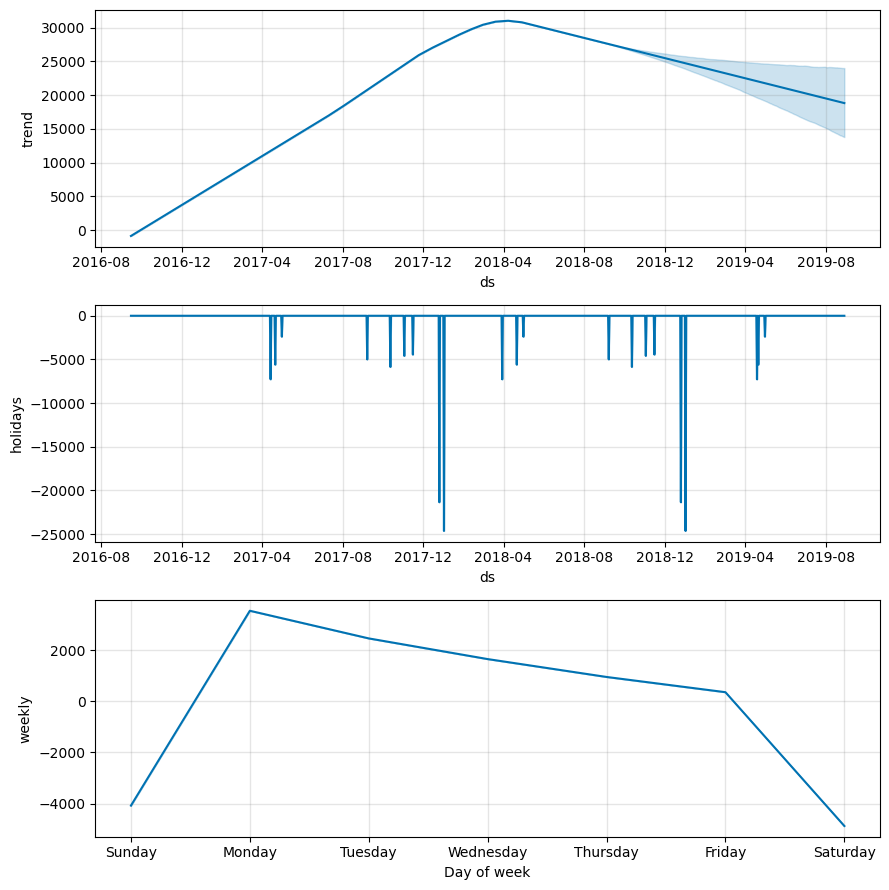

In [53]:

# Plot the components (including holidays)
fig = m.plot_components(forecast_with_holidays)
fig.show()

Create a new csv file

In [54]:
important_columns = [
    'ds',              # Date
    'yhat',            # Forecast
    'yhat_lower',      # Lower bound of forecast
    'yhat_upper',      # Upper bound of forecast
    'trend',           # Trend component
    'weekly',          # Weekly seasonality
    'holidays'         # Combined holiday effect
]

In [55]:
# Add individual holiday columns
holiday_columns = [col for col in forecast.columns if col not in [
    'ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
    'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
    'weekly', 'weekly_lower', 'weekly_upper',
    'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper'
]]

In [56]:
important_columns.extend(holiday_columns)

In [57]:
sales_forecast_with_holidays = forecast_with_holidays[important_columns]

In [58]:
sales_forecast_with_holidays = sales_forecast_with_holidays.rename(columns={
                                'ds':'purchase_date',
                                'yhat': 'total_sales_forecast',
                                'yhat_lower':'total_sales_lower_bound',
                                'yhat_upper':'total_sales_upper_bound',
                                'trend': 'trend_component',
                                'holidays': 'combined_holiday_effect'
                                })

In [59]:
sales_forecast_with_holidays.head(3)

,purchase_date,total_sales_forecast,total_sales_lower_bound,total_sales_upper_bound,trend_component,weekly,combined_holiday_effect
0,2016-09-15,82.342647,-10120.279406,10477.342861,-868.109463,950.452110,0.0
1,2016-10-03,3743.966231,-6941.196187,13941.901933,206.481612,3537.484619,0.0
2,2016-10-04,2723.042546,-7088.396924,12873.513896,266.181117,2456.861430,0.0


In [60]:
sales_forecast_with_holidays.to_csv('../../data/cleaned/sales_forecast_with_holidays.csv', index=False)

In [61]:
sales_forecast.dtypes

purchase_date              datetime64[ns]
total_sales_forecast              float64
total_sales_lower_bound           float64
total_sales_upper_bound           float64
trend_component                   float64
weekly                            float64
sum_seasonal_components           float64
dtype: object

In [62]:
sales_forecast_with_holidays.dtypes

purchase_date              datetime64[ns]
total_sales_forecast              float64
total_sales_lower_bound           float64
total_sales_upper_bound           float64
trend_component                   float64
weekly                            float64
combined_holiday_effect           float64
dtype: object

In [63]:
# plot

sales_per_day.columns

Index(['ds', 'y'], dtype='object')

In [64]:
sales_forecast.columns

Index(['purchase_date', 'total_sales_forecast', 'total_sales_lower_bound',
       'total_sales_upper_bound', 'trend_component', 'weekly',
       'sum_seasonal_components'],
      dtype='object')

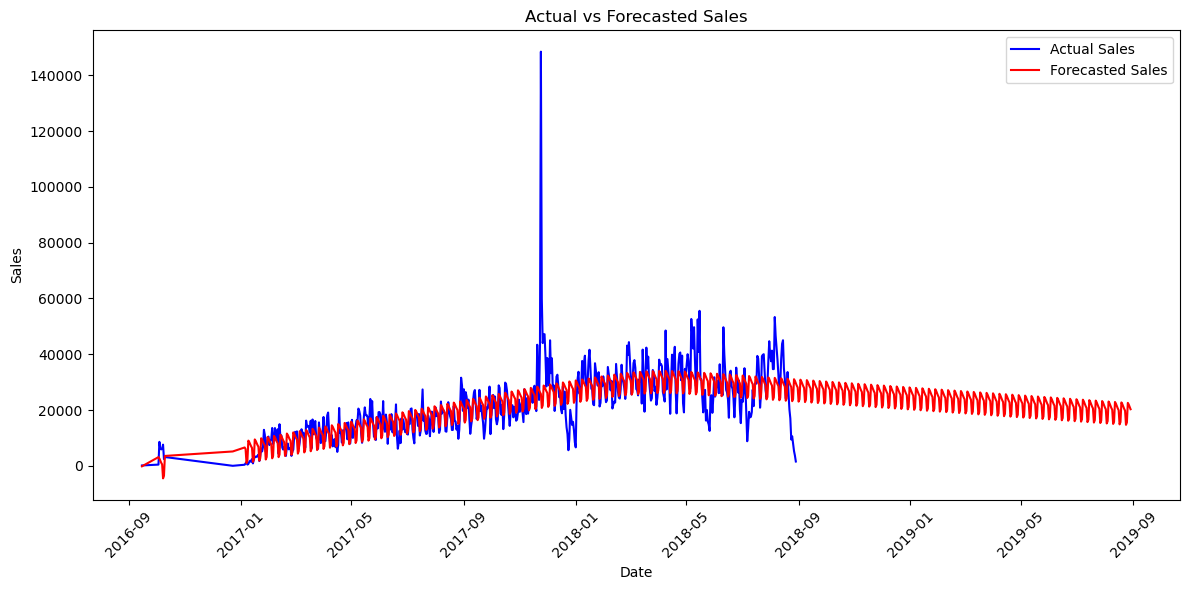

In [65]:
# Convert 'ds' and 'purchase_date' to datetime if they're not already
sales_per_day['ds'] = pd.to_datetime(sales_per_day['ds'])
sales_forecast['purchase_date'] = pd.to_datetime(sales_forecast['purchase_date'])

# Create the plot
plt.figure(figsize=(12, 6))

# Plot actual sales
plt.plot(sales_per_day['ds'], sales_per_day['y'], label='Actual Sales', color='blue')

# Plot forecasted sales
plt.plot(sales_forecast['purchase_date'], sales_forecast['total_sales_forecast'], label='Forecasted Sales', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Forecasted Sales')

# Add legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot

## Estimated Delivery Date Prediction

In [66]:
df_logistics = pd.read_csv('../../data/cleaned/df_logistics.csv',parse_dates=['purchase_timestamp','approved_timestamp','delivered_carrier_timestamp','delivered_customer_timestamp','estimated_delivery_timestamp','shipping_limit_timestamp'])
df_logistics = df_logistics.copy()

In [67]:
df_logistics.drop(columns='Unnamed: 0', inplace=True)

In [68]:
df_logistics.dtypes

order_id                                object
customer_id                             object
status                                  object
purchase_timestamp              datetime64[ns]
approved_timestamp              datetime64[ns]
delivered_carrier_timestamp     datetime64[ns]
delivered_customer_timestamp    datetime64[ns]
estimated_delivery_timestamp    datetime64[ns]
delivery_status                         object
city_customer                           object
state_customer                          object
latitude_customer                      float64
longitude_customer                     float64
seller_id                               object
shipping_limit_timestamp        datetime64[ns]
freight_value                          float64
city_seller                             object
state_code_seller                       object
latitude_seller                        float64
longitude_seller                       float64
distance                               float64
delivery_dura

In [69]:
df_estimated_delivery = df_logistics[df_logistics['status'] == 'delivered']

In [70]:
data_exploration(df_estimated_delivery)

Number of rows: 96258
Number of columns: 23
Number of duplicates: 0

Numerical Columns: Index(['latitude_customer', 'longitude_customer', 'freight_value',
       'latitude_seller', 'longitude_seller', 'distance', 'delivery_duration',
       'estimated_duration'],
      dtype='object')

Categorical Columns: Index(['order_id', 'customer_id', 'status', 'delivery_status', 'city_customer',
       'state_customer', 'seller_id', 'city_seller', 'state_code_seller'],
      dtype='object')


,Column,Data Type,Non-Null Count,Missing Values,Unique Values
0,order_id,object,96258,0,93869
1,customer_id,object,96258,0,93869
2,status,object,96258,0,1
3,purchase_timestamp,datetime64[ns],96258,0,93364
4,approved_timestamp,datetime64[ns],96244,14,86038
5,delivered_carrier_timestamp,datetime64[ns],96256,2,78101
6,delivered_customer_timestamp,datetime64[ns],96250,8,93085
7,estimated_delivery_timestamp,datetime64[ns],96258,0,445
8,delivery_status,object,96258,0,2
9,city_customer,object,96258,0,3969


Drop missing value in delivered_customer_timestamp.

In [71]:
df_estimated_delivery = df_estimated_delivery.dropna(subset='delivered_customer_timestamp')

In [72]:
reference_date = pd.to_datetime(df_estimated_delivery['purchase_timestamp'].min().date())

In [73]:
reference_date

Timestamp('2016-09-15 00:00:00')

In [74]:
df_estimated_delivery['purchase_date'] = df_estimated_delivery['purchase_timestamp'] - reference_date
df_estimated_delivery['purchase_date'] = df_estimated_delivery['purchase_date'].dt.days

In [75]:
df_estimated_delivery['delivered_date'] = df_estimated_delivery['delivered_customer_timestamp'] - reference_date
df_estimated_delivery['delivered_date'] = df_estimated_delivery['delivered_date'].dt.days

In [76]:
df_estimated_delivery['purchase_hour'] = df_estimated_delivery['purchase_timestamp'].dt.hour.astype(np.int64)

In [77]:
df_estimated_delivery['estimated_delivery_original'] = df_estimated_delivery['estimated_delivery_timestamp'] - reference_date
df_estimated_delivery['estimated_delivery_original'] = df_estimated_delivery['estimated_delivery_original'].dt.days

In [78]:
df_estimated_delivery.head()

,order_id,customer_id,status,purchase_timestamp,approved_timestamp,delivered_carrier_timestamp,delivered_customer_timestamp,estimated_delivery_timestamp,delivery_status,city_customer,...,state_code_seller,latitude_seller,longitude_seller,distance,delivery_duration,estimated_duration,purchase_date,delivered_date,purchase_hour,estimated_delivery_original
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,on-time,sao paulo,...,SP,-23.680884,-46.444255,22.87,6,15,382,390,10,398
1,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,on-time,vianopolis,...,SP,-21.363473,-48.229588,31.49,9,26,692,701,8,719
2,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,on-time,sao goncalo do amarante,...,MG,-19.836871,-43.923241,39.12,9,26,429,443,19,456
3,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,on-time,santo andre,...,SP,-23.541525,-46.262148,22.59,1,12,516,519,21,529
4,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,on-time,congonhinhas,...,SP,-23.469087,-46.515649,23.31,14,22,297,314,21,320


In [79]:
df_estimated_delivery.dtypes

order_id                                object
customer_id                             object
status                                  object
purchase_timestamp              datetime64[ns]
approved_timestamp              datetime64[ns]
delivered_carrier_timestamp     datetime64[ns]
delivered_customer_timestamp    datetime64[ns]
estimated_delivery_timestamp    datetime64[ns]
delivery_status                         object
city_customer                           object
state_customer                          object
latitude_customer                      float64
longitude_customer                     float64
seller_id                               object
shipping_limit_timestamp        datetime64[ns]
freight_value                          float64
city_seller                             object
state_code_seller                       object
latitude_seller                        float64
longitude_seller                       float64
distance                               float64
delivery_dura

Take only the columns required for machine learning process into the dataframe: <br>
- purchase_timestamp (split into date and time in different columns). <br>
- delivered_customer_timestamp (take its date only). <br>
- distance. <br>

In [80]:
df_estimated_delivery = df_estimated_delivery[['purchase_date','purchase_hour','distance','delivered_date','estimated_delivery_original']]

In [81]:
df_estimated_delivery

,purchase_date,purchase_hour,distance,delivered_date,estimated_delivery_original
0,382,10,22.87,390,398
1,692,8,31.49,701,719
2,429,19,39.12,443,456
3,516,21,22.59,519,529
4,297,21,23.31,314,320
...,...,...,...,...,...
98386,175,9,23.36,183,194
98387,509,12,26.80,531,533
98388,346,14,29.42,371,377
98389,480,21,23.47,497,518


In [82]:
df_estimated_delivery.dtypes

purchase_date                    int64
purchase_hour                    int64
distance                       float64
delivered_date                   int64
estimated_delivery_original      int64
dtype: object

### Check Correlation

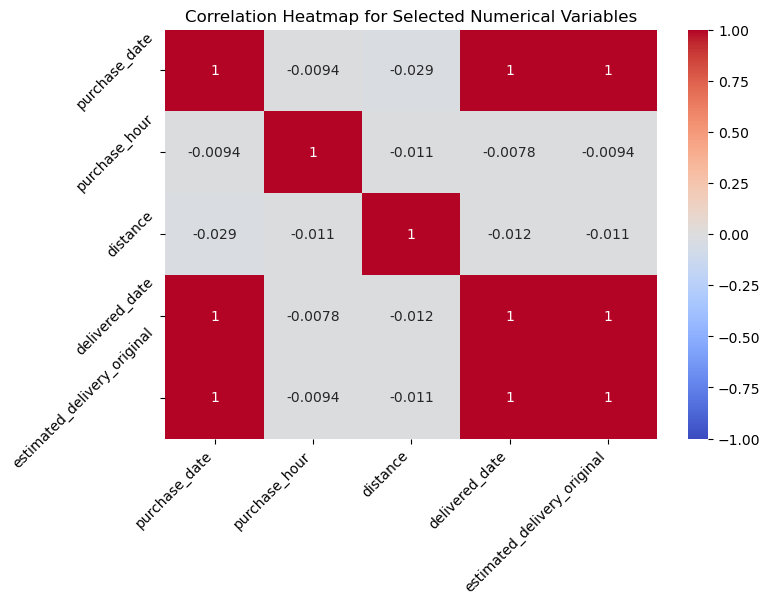

In [83]:
correlation_matrix = df_estimated_delivery.select_dtypes(include=[np.number]).corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(8, 6))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap="coolwarm", 
            vmin=-1,  # Set the minimum of the colorbar to -1
            vmax=1,   # Set the maximum of the colorbar to 1
            center=0) # Center the colorbar at 0

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Rotate y-axis labels
plt.yticks(rotation=45, ha='right')

# Adjust the bottom and top of the plot to ensure labels are not cut off
plt.tight_layout()

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

### Feature Engineering - add sin cos

In [84]:
df_estimated_delivery = cyclical_encoding(df_estimated_delivery, 'purchase_hour', 24)
df_estimated_delivery = cyclical_encoding(df_estimated_delivery, 'purchase_date', 365)

In [85]:
df_estimated_delivery = df_estimated_delivery.reset_index()

In [86]:
df_estimated_delivery.head()

,index,purchase_date,purchase_hour,distance,delivered_date,estimated_delivery_original,purchase_hour_sin,purchase_hour_cos,purchase_date_sin,purchase_date_cos
0,0,382,10,22.87,390,398,0.500000,-0.866025,0.288482,0.957485
1,1,692,8,31.49,701,719,0.866025,-0.500000,-0.608477,0.793572
2,2,429,19,39.12,443,456,-0.965926,0.258819,0.891981,0.452072
3,3,516,21,22.59,519,529,-0.707107,0.707107,0.516062,-0.856551
4,4,297,21,23.31,314,320,-0.707107,0.707107,-0.920971,0.389630


In [87]:
df_estimated_delivery.drop(columns='index', inplace=True)

In [88]:
df_estimated_delivery.head()

,purchase_date,purchase_hour,distance,delivered_date,estimated_delivery_original,purchase_hour_sin,purchase_hour_cos,purchase_date_sin,purchase_date_cos
0,382,10,22.87,390,398,0.500000,-0.866025,0.288482,0.957485
1,692,8,31.49,701,719,0.866025,-0.500000,-0.608477,0.793572
2,429,19,39.12,443,456,-0.965926,0.258819,0.891981,0.452072
3,516,21,22.59,519,529,-0.707107,0.707107,0.516062,-0.856551
4,297,21,23.31,314,320,-0.707107,0.707107,-0.920971,0.389630


In [89]:
df_estimated_delivery.dtypes

purchase_date                    int64
purchase_hour                    int64
distance                       float64
delivered_date                   int64
estimated_delivery_original      int64
purchase_hour_sin              float64
purchase_hour_cos              float64
purchase_date_sin              float64
purchase_date_cos              float64
dtype: object

In [90]:
data_exploration(df_estimated_delivery)

Number of rows: 96250
Number of columns: 9
Number of duplicates: 1397

Numerical Columns: Index(['purchase_date', 'purchase_hour', 'distance', 'delivered_date',
       'estimated_delivery_original', 'purchase_hour_sin', 'purchase_hour_cos',
       'purchase_date_sin', 'purchase_date_cos'],
      dtype='object')

Categorical Columns: Index([], dtype='object')


,Column,Data Type,Non-Null Count,Missing Values,Unique Values
0,purchase_date,int64,96250,0,612
1,purchase_hour,int64,96250,0,24
2,distance,float64,96250,0,3492
3,delivered_date,int64,96250,0,645
4,estimated_delivery_original,int64,96250,0,445
5,purchase_hour_sin,float64,96250,0,21
6,purchase_hour_cos,float64,96250,0,22
7,purchase_date_sin,float64,96250,0,597
8,purchase_date_cos,float64,96250,0,547


In [91]:
# Identify rows where all column values are duplicated
all_duplicates = df_estimated_delivery.duplicated(keep=False)

# Filter and display these rows
duplicate_rows = df_estimated_delivery[all_duplicates]
print(duplicate_rows)


       purchase_date  purchase_hour  distance  delivered_date  \
81               449              9     25.10             460   
117              562             14     25.86             569   
118              562             14     25.86             569   
133              194             16     23.60             197   
134              194             16     23.60             197   
...              ...            ...       ...             ...   
96124            628             12     26.58             630   
96177            192             14     23.40             195   
96178            192             14     23.40             195   
96241            384             19     30.61             400   
96242            384             19     30.61             400   

       estimated_delivery_original  purchase_hour_sin  purchase_hour_cos  \
81                             475       7.071068e-01          -0.707107   
117                            596      -5.000000e-01          -0.8

In [92]:
df_estimated_delivery = df_estimated_delivery.drop_duplicates(keep='first')

In [93]:
data_exploration(df_estimated_delivery)

Number of rows: 94853
Number of columns: 9
Number of duplicates: 0

Numerical Columns: Index(['purchase_date', 'purchase_hour', 'distance', 'delivered_date',
       'estimated_delivery_original', 'purchase_hour_sin', 'purchase_hour_cos',
       'purchase_date_sin', 'purchase_date_cos'],
      dtype='object')

Categorical Columns: Index([], dtype='object')


,Column,Data Type,Non-Null Count,Missing Values,Unique Values
0,purchase_date,int64,94853,0,612
1,purchase_hour,int64,94853,0,24
2,distance,float64,94853,0,3492
3,delivered_date,int64,94853,0,645
4,estimated_delivery_original,int64,94853,0,445
5,purchase_hour_sin,float64,94853,0,21
6,purchase_hour_cos,float64,94853,0,22
7,purchase_date_sin,float64,94853,0,597
8,purchase_date_cos,float64,94853,0,547


In [94]:
analyze_outliers_zscore(df_estimated_delivery)

,Column,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound,Min Outlier,Max Outlier
2,distance,1739,1.83%,8.435622,44.270339,44.28,59.4
3,delivered_date,32,0.03%,29.949067,942.132238,26.00,29.0
4,estimated_delivery_original,2,0.0%,44.997937,950.966429,19.00,42.0
0,purchase_date,1,0.0%,15.569672,931.650216,0.00,0.0
1,purchase_hour,0,0.0%,-1.222747,30.768550,NaN,NaN
5,purchase_hour_sin,0,0.0%,-2.107538,1.444707,NaN,NaN
6,purchase_hour_cos,0,0.0%,-2.322712,1.882235,NaN,NaN
7,purchase_date_sin,0,0.0%,-2.234694,2.002222,NaN,NaN
8,purchase_date_cos,0,0.0%,-2.168134,1.987415,NaN,NaN


In [95]:
remove_outliers_zscore(df_estimated_delivery)

Removed 1773 rows


,purchase_date,purchase_hour,distance,delivered_date,estimated_delivery_original,purchase_hour_sin,purchase_hour_cos,purchase_date_sin,purchase_date_cos
0,382,10,22.87,390,398,5.000000e-01,-0.866025,0.288482,0.957485
1,692,8,31.49,701,719,8.660254e-01,-0.500000,-0.608477,0.793572
2,429,19,39.12,443,456,-9.659258e-01,0.258819,0.891981,0.452072
3,516,21,22.59,519,529,-7.071068e-01,0.707107,0.516062,-0.856551
4,297,21,23.31,314,320,-7.071068e-01,0.707107,-0.920971,0.389630
...,...,...,...,...,...,...,...,...,...
96245,175,9,23.36,183,194,7.071068e-01,-0.707107,0.128748,-0.991677
96246,509,12,26.80,531,533,1.224647e-16,-1.000000,0.615285,-0.788305
96247,346,14,29.42,371,377,-5.000000e-01,-0.866025,-0.321270,0.946988
96248,480,21,23.47,497,518,-7.071068e-01,0.707107,0.917584,-0.397543


In [96]:
df_estimated_delivery = remove_outliers_zscore(df_estimated_delivery)

Removed 1773 rows


### Define Features and Target

In [97]:
X = df_estimated_delivery.drop(columns=['delivered_date','estimated_delivery_original'])
y = df_estimated_delivery['delivered_date']

### Split The Data

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

### Data standardization

In [99]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train The Models

In [100]:
# performance_df = train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test) # 1 minute to run

In [101]:
# performance_df

### Hyperparameter tuning

In [102]:
# tuned_results = hyperparameter_tuning(X_train_scaled, X_test_scaled, y_train, y_test, performance_df) # 22 minutes to run

In [103]:
# tuned_results

In [104]:
#for index, row in tuned_results.iterrows():
    # print(f"Model: {index}")
    # for column, value in row.items():
    #     print(f"{column}: {value}")
    # print("\n")

Based on the hypertuning parameter result, we can conclude: <br>
- Best model: XGBoost. <br>
- Best parameter: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}. <br>
- Mean Squared Error: 69.234343. <br>
- Mean Absolute Error: 5.201501. <br>
- R-squared Score: 0.996997. <br>

### Predict Estimated Delivery Date with Best Model

**XGBoost**

In [105]:
# Best parameter = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

xgb_regressor = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, random_state=42)
# xgb_regressor.fit(X_train, y_train)

In [106]:
# Combine the features and target variables
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)


In [107]:
xgb_regressor.fit(X_full,y_full)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [108]:
df_estimated_delivery_2 = df_estimated_delivery.copy()
df_estimated_delivery_2 = df_estimated_delivery_2.drop(columns='delivered_date')

In [109]:
expected_columns = df_estimated_delivery.columns

In [110]:
# Reindex the second dataset to match the columns used during training
df_estimated_delivery_2 = df_estimated_delivery_2.reindex(columns=expected_columns, fill_value=0)

In [111]:
xgb_regressor = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, random_state=42)

# Combine the features and target variables for training
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

# Fit the model
xgb_regressor.fit(X_full, y_full)

# Prepare the prediction DataFrame
df_estimated_delivery_2 = df_estimated_delivery.copy()

# Drop the target variable as it's not a feature
df_estimated_delivery_2 = df_estimated_delivery_2.drop(columns=['delivered_date'])

# Ensure the columns in df_estimated_delivery_2 match those in the training data
df_estimated_delivery_2 = df_estimated_delivery_2[X_full.columns]



In [112]:
# Make predictions
df_estimated_delivery_2['estimated_delivery_prediction'] = xgb_regressor.predict(df_estimated_delivery_2).astype(np.int64)

In [113]:
df_estimated_delivery_2.dtypes

purchase_date                      int64
purchase_hour                      int64
distance                         float64
purchase_hour_sin                float64
purchase_hour_cos                float64
purchase_date_sin                float64
purchase_date_cos                float64
estimated_delivery_prediction      int64
dtype: object

In [114]:
df_estimated_delivery_2

,purchase_date,purchase_hour,distance,purchase_hour_sin,purchase_hour_cos,purchase_date_sin,purchase_date_cos,estimated_delivery_prediction
0,382,10,22.87,5.000000e-01,-0.866025,0.288482,0.957485,388
1,692,8,31.49,8.660254e-01,-0.500000,-0.608477,0.793572,701
2,429,19,39.12,-9.659258e-01,0.258819,0.891981,0.452072,448
3,516,21,22.59,-7.071068e-01,0.707107,0.516062,-0.856551,527
4,297,21,23.31,-7.071068e-01,0.707107,-0.920971,0.389630,303
...,...,...,...,...,...,...,...,...
96245,175,9,23.36,7.071068e-01,-0.707107,0.128748,-0.991677,184
96246,509,12,26.80,1.224647e-16,-1.000000,0.615285,-0.788305,523
96247,346,14,29.42,-5.000000e-01,-0.866025,-0.321270,0.946988,356
96248,480,21,23.47,-7.071068e-01,0.707107,0.917584,-0.397543,489


In [115]:
df_estimated_delivery

,purchase_date,purchase_hour,distance,delivered_date,estimated_delivery_original,purchase_hour_sin,purchase_hour_cos,purchase_date_sin,purchase_date_cos
0,382,10,22.87,390,398,5.000000e-01,-0.866025,0.288482,0.957485
1,692,8,31.49,701,719,8.660254e-01,-0.500000,-0.608477,0.793572
2,429,19,39.12,443,456,-9.659258e-01,0.258819,0.891981,0.452072
3,516,21,22.59,519,529,-7.071068e-01,0.707107,0.516062,-0.856551
4,297,21,23.31,314,320,-7.071068e-01,0.707107,-0.920971,0.389630
...,...,...,...,...,...,...,...,...,...
96245,175,9,23.36,183,194,7.071068e-01,-0.707107,0.128748,-0.991677
96246,509,12,26.80,531,533,1.224647e-16,-1.000000,0.615285,-0.788305
96247,346,14,29.42,371,377,-5.000000e-01,-0.866025,-0.321270,0.946988
96248,480,21,23.47,497,518,-7.071068e-01,0.707107,0.917584,-0.397543


Save the model in a pkl file.

In [125]:
xgb_regressor = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, random_state=42)
xgb_regressor.fit(X_full,y_full)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [126]:
with open('../../src/eta_prediction.pkl', 'wb') as file:
    pickle.dump(xgb_regressor, file)

Save to a new csv file

In [ ]:
df_estimated_delivery.to_csv('../../data/cleaned/df_eta_original.csv', index=False)

In [ ]:
df_estimated_delivery_2.to_csv('../../data/cleaned/df_eta_prediction.csv', index=False)

Company's Estimate Performance:
MAE: 13.30 days
MSE: 242.75
RMSE: 15.58 days
R2 Score: 0.99

Model's Prediction Performance:
MAE: 4.95 days
MSE: 64.70
RMSE: 8.04 days
R2 Score: 1.00

Your model improves MAE by 62.75%
Your model improves RMSE by 48.38%


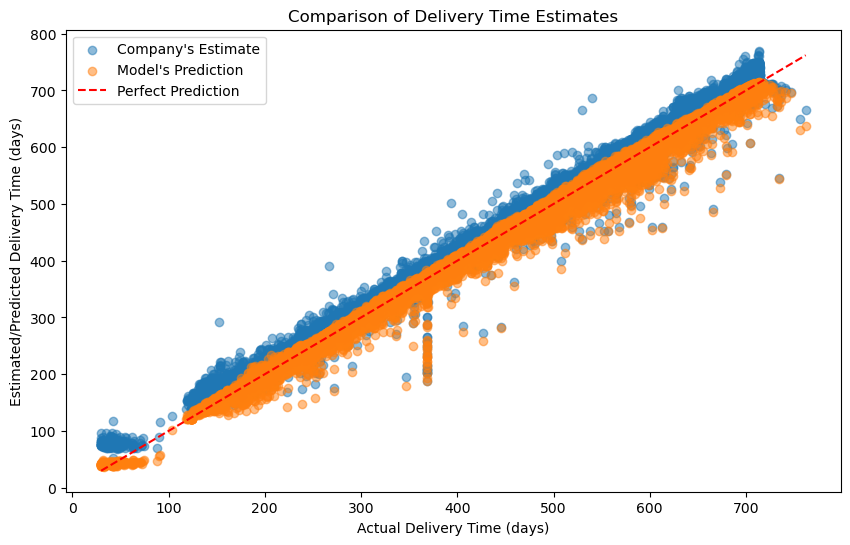

In [ ]:
# Calculate metrics for company's estimate
company_mae = mean_absolute_error(df_estimated_delivery['delivered_date'], df_estimated_delivery['estimated_delivery_original'])
company_mse = mean_squared_error(df_estimated_delivery['delivered_date'], df_estimated_delivery['estimated_delivery_original'])
company_rmse = np.sqrt(company_mse)
company_r2 = r2_score(df_estimated_delivery['delivered_date'], df_estimated_delivery['estimated_delivery_original'])

# Calculate metrics for your model's prediction
model_mae = mean_absolute_error(df_estimated_delivery['delivered_date'], df_estimated_delivery_2['estimated_delivery_prediction'])
model_mse = mean_squared_error(df_estimated_delivery['delivered_date'], df_estimated_delivery_2['estimated_delivery_prediction'])
model_rmse = np.sqrt(model_mse)
model_r2 = r2_score(df_estimated_delivery['delivered_date'], df_estimated_delivery_2['estimated_delivery_prediction'])

# Print results
print("Company's Estimate Performance:")
print(f"MAE: {company_mae:.2f} days")
print(f"MSE: {company_mse:.2f}")
print(f"RMSE: {company_rmse:.2f} days")
print(f"R2 Score: {company_r2:.2f}")

print("\nModel's Prediction Performance:")
print(f"MAE: {model_mae:.2f} days")
print(f"MSE: {model_mse:.2f}")
print(f"RMSE: {model_rmse:.2f} days")
print(f"R2 Score: {model_r2:.2f}")

# Calculate percentage improvement
mae_improvement = (company_mae - model_mae) / company_mae * 100
rmse_improvement = (company_rmse - model_rmse) / company_rmse * 100

print(f"\nYour model improves MAE by {mae_improvement:.2f}%")
print(f"Your model improves RMSE by {rmse_improvement:.2f}%")

# Visualize the comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_estimated_delivery['delivered_date'], df_estimated_delivery['estimated_delivery_original'], alpha=0.5, label="Company's Estimate")
plt.scatter(df_estimated_delivery['delivered_date'], df_estimated_delivery_2['estimated_delivery_prediction'], alpha=0.5, label="Model's Prediction")
plt.plot([df_estimated_delivery['delivered_date'].min(), df_estimated_delivery['delivered_date'].max()], 
         [df_estimated_delivery['delivered_date'].min(), df_estimated_delivery['delivered_date'].max()], 
         'r--', label="Perfect Prediction")
plt.xlabel("Actual Delivery Time (days)")
plt.ylabel("Estimated/Predicted Delivery Time (days)")
plt.legend()
plt.title("Comparison of Delivery Time Estimates")
plt.show()

Check if we can create an additional column for both df_eta_original and df_eta_prediction as unique value and to connect both of them in SQL.

In [ ]:
df_estimated_delivery["estimated_date_unique_id"] = (
    df_estimated_delivery['purchase_date'].astype(str) + '_' + 
    df_estimated_delivery['purchase_hour'].astype(str) + '_' + 
    df_estimated_delivery['distance'].astype(str) 
    )

In [ ]:
df_estimated_delivery

,purchase_date,purchase_hour,distance,delivered_date,estimated_delivery_original,purchase_hour_sin,purchase_hour_cos,purchase_date_sin,purchase_date_cos,estimated_date_unique_id
0,382,10,22.87,390,398,5.000000e-01,-0.866025,0.288482,0.957485,382_10_22.87
1,692,8,31.49,701,719,8.660254e-01,-0.500000,-0.608477,0.793572,692_8_31.49
2,429,19,39.12,443,456,-9.659258e-01,0.258819,0.891981,0.452072,429_19_39.12
3,516,21,22.59,519,529,-7.071068e-01,0.707107,0.516062,-0.856551,516_21_22.59
4,297,21,23.31,314,320,-7.071068e-01,0.707107,-0.920971,0.389630,297_21_23.31
...,...,...,...,...,...,...,...,...,...,...
96245,175,9,23.36,183,194,7.071068e-01,-0.707107,0.128748,-0.991677,175_9_23.36
96246,509,12,26.80,531,533,1.224647e-16,-1.000000,0.615285,-0.788305,509_12_26.8
96247,346,14,29.42,371,377,-5.000000e-01,-0.866025,-0.321270,0.946988,346_14_29.42
96248,480,21,23.47,497,518,-7.071068e-01,0.707107,0.917584,-0.397543,480_21_23.47


In [ ]:
df_estimated_delivery_2["estimated_date_unique_id"] = (
    df_estimated_delivery_2['purchase_date'].astype(str) + '_' + 
    df_estimated_delivery_2['purchase_hour'].astype(str) + '_' + 
    df_estimated_delivery_2['distance'].astype(str) 
    )

In [ ]:
df_estimated_delivery_2.head()

,purchase_date,purchase_hour,distance,purchase_hour_sin,purchase_hour_cos,purchase_date_sin,purchase_date_cos,estimated_delivery_prediction,estimated_date_unique_id
0,382,10,22.87,0.500000,-0.866025,0.288482,0.957485,388,382_10_22.87
1,692,8,31.49,0.866025,-0.500000,-0.608477,0.793572,701,692_8_31.49
2,429,19,39.12,-0.965926,0.258819,0.891981,0.452072,448,429_19_39.12
3,516,21,22.59,-0.707107,0.707107,0.516062,-0.856551,527,516_21_22.59
4,297,21,23.31,-0.707107,0.707107,-0.920971,0.389630,303,297_21_23.31


In [ ]:
df_estimated_delivery_2.duplicated().sum()

804

In [ ]:
duplicate_rows = df_estimated_delivery_2[df_estimated_delivery_2.duplicated()]
print(duplicate_rows)

       purchase_date  purchase_hour  distance  purchase_hour_sin  \
3679             435              9     23.87       7.071068e-01   
6083             675             22     22.85      -5.000000e-01   
6952             526             20     28.53      -8.660254e-01   
7163             206              9     25.81       7.071068e-01   
9585             706             14     22.93      -5.000000e-01   
...              ...            ...       ...                ...   
96010            502             10     27.60       5.000000e-01   
96013            515              3     28.64       7.071068e-01   
96015            510              1     20.96       2.588190e-01   
96022            453             23     20.00      -2.588190e-01   
96123            628             12     26.58       1.224647e-16   

       purchase_hour_cos  purchase_date_sin  purchase_date_cos  \
3679           -0.707107           0.933837           0.357698   
6083            0.866025          -0.811539        

In [ ]:
df_estimated_delivery_2[df_estimated_delivery_2["estimated_date_unique_id"] == '453_23_20.0']

,purchase_date,purchase_hour,distance,purchase_hour_sin,purchase_hour_cos,purchase_date_sin,purchase_date_cos,estimated_delivery_prediction,estimated_date_unique_id
56707,453,23,20.0,-0.258819,0.965926,0.998435,0.055917,469,453_23_20.0
96022,453,23,20.0,-0.258819,0.965926,0.998435,0.055917,469,453_23_20.0


In [ ]:
df_estimated_delivery_2_without_duplicates = df_estimated_delivery_2.copy()

In [ ]:
df_estimated_delivery_2_without_duplicates = df_estimated_delivery_2_without_duplicates.drop_duplicates()

In [ ]:
df_estimated_delivery_2_without_duplicates.shape

(92276, 9)

We will keep the df_estimated_2 with duplicates as it is just in case later it's needed. So, let's not create unique_id for both of them here, but in SQL.

## Import csv to MySQL

Connect with MySQL

In [119]:
# Load environment variables from .env file
load_dotenv()

# Access the password
password = os.getenv('mySQL_password')

database = "mydb"
connection_string = 'mysql+pymysql://root:' + password + '@localhost/'+ database
engine = create_engine(connection_string)

1. sales_forecast

In [262]:
sales_forecast = pd.read_csv('../../data/cleaned/sales_forecast.csv')
sales_forecast.to_sql('sales_forecast', con=engine, index=False, if_exists='append')

977

2. sales_forecast_with_holidays

In [263]:
sales_forecast_with_holidays = pd.read_csv('../../data/cleaned/sales_forecast_with_holidays.csv')
sales_forecast_with_holidays.to_sql('sales_forecast_with_holidays', con=engine, index=False, if_exists='append')

977

3. df_eta_original

In [264]:
df_eta_original = pd.read_csv('../../data/cleaned/df_eta_original.csv')
df_eta_original.to_sql('df_eta_original', con=engine, index=False, if_exists='append')

93080

4. df_eta_prediction

In [120]:
df_eta_prediction = pd.read_csv('../../data/cleaned/df_eta_prediction.csv')
df_eta_prediction.to_sql('df_eta_prediction', con=engine, index=False, if_exists='append')

93080